**W. Christopher Carleton¹**, **Sarah Klassen²**, **John T. Murphy³**, **Patrick Roberts¹**  

¹ *Department of Coevolution of Land Use and Urbanisation, Max Planck Institute of Geoanthropology, Jena, Germany* 
² *Center for Collaborative Synthesis in Archaeology, University of Colorado, Boulder, Colorado, USA*  
³ *Department of Anthropology, Northern Illinois University, Dekalb, Illinois, USA*  

emails: carleton@gea.mpg.de, sarah.klassen@colorado.edu, jmurphy7@niu.edu, roberts@gea.mpg.de

## Overview
This computational notebook contains the code necessary to rerun the analyses described in the associated paper. In order to gather and prepare the data used in this notebook for the Hampshire case, run the other computational notebook in the same folder ("doomsday.ipynb") first. Then, run all of the following code in order. 

## Set Up
### Libraries

In [1]:
# core
import numpy as np
import pandas as pd
from scipy.stats import norm
import warnings

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

# chronocluster
from chronocluster import clustering
from chronocluster.utils import (
    clustering_heatmap, 
    pdiff_heatmap, 
    get_box, 
    chrono_plot, 
    chrono_plot2d, 
    inclusion_legend
)
from chronocluster.distributions import ddelta

### Plot Styling

In [2]:
# basic styling
plt.style.use('ggplot')
sns.set_context("paper")

# matplotlib fonts
mpl.rcParams["font.size"] = 12
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["legend.fontsize"] = 10
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams['figure.facecolor'] = 'white'

### NOTE: Warnings
Some of the plotting workarounds have generated immaterial warnings below. In order to avoid these showing up in a PDF or HTML version of this notebook, like the one that will be subimitted as SI alongside the associated paper, run the next cell. In order to see the warnings, remove the cell or change plot_warnings to True.

In [3]:
plot_warnings = False
if not plot_warnings:
    warnings.filterwarnings("ignore")

## Angkor 
### Data Wrangling

In [4]:
# data wrangling
df = pd.read_csv('../Data/temples_with_predicted_ages.csv')
df = df.dropna(subset=['xeast', 'ynorth', 'model_age_mean'])

#### Create Points List

In [5]:
points = [
    clustering.Point(
        x=row['xeast'],
        y=row['ynorth'],
        start_distribution = (
            ddelta(d=row['model_age_mean']) 
            if row['model_age_sd'] == 0 
            else norm(loc=row['model_age_mean'], scale=row['model_age_sd'])
            ),
        end_distribution = ddelta(1500)
    )
    for _, row in df.iterrows()
]

# just double check the first ten look right
points[:10]
angkor_points = points

#### Figure S1: Spacetime Volume of Angkor's Temples

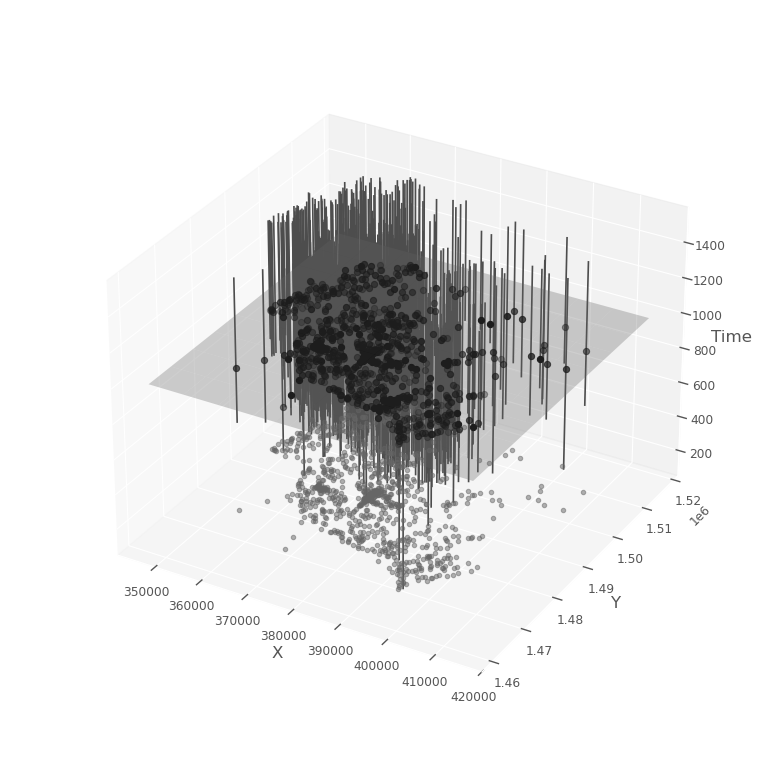

In [6]:
# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a 
# time slice plane
ax_stv_angkor, fig_stv_angkor = chrono_plot(points, 
                                            style_params=style_params, 
                                            time_slice=1000,
                                            title='Angkor')
ax_stv_angkor.set_box_aspect(None, zoom=0.85)
plt.savefig("../Output/spacetime_volume_Angkor.svg", bbox_inches='tight') 

#### Define Time Slices

In [7]:
# Define the time slices
start_time = 800
end_time = 1200
time_interval = 50
time_slices = np.arange(start_time, end_time, time_interval)
time_slices

array([ 800,  850,  900,  950, 1000, 1050, 1100, 1150])

#### GPU Boosted Pairwise Distance Density KDEs

In [8]:
from cuml.neighbors import KernelDensity

def cuml_kde(distances, bandwidth, **kwargs):
    distances = np.array(distances).reshape(-1, 1)

    if bandwidth is None:
        n = len(distances)
        if n < 2:
            raise ValueError(
                "Data must contain at least 2 points ", 
                "for bandwidth calculation."
            )
        std_dev = np.std(distances, ddof=1)
        bandwidth = std_dev * n ** (-1 / 5)
    
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth, **kwargs)
    kde.fit(distances)

    def kde_function(points):
        points = np.array(points).reshape(-1, 1)
        # score_samples returns a cupy array; use .get() to convert to NumPy
        return np.exp(kde.score_samples(points).get())
    
    return kde_function

#### Figure S2: Heatmap of Pairwise Distance Density versus Time at Angkor

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Heatmap of Mean Pairwise Distances(d) Function Over Time and Distance'}, xlabel='Time Slices', ylabel='Distances'>)

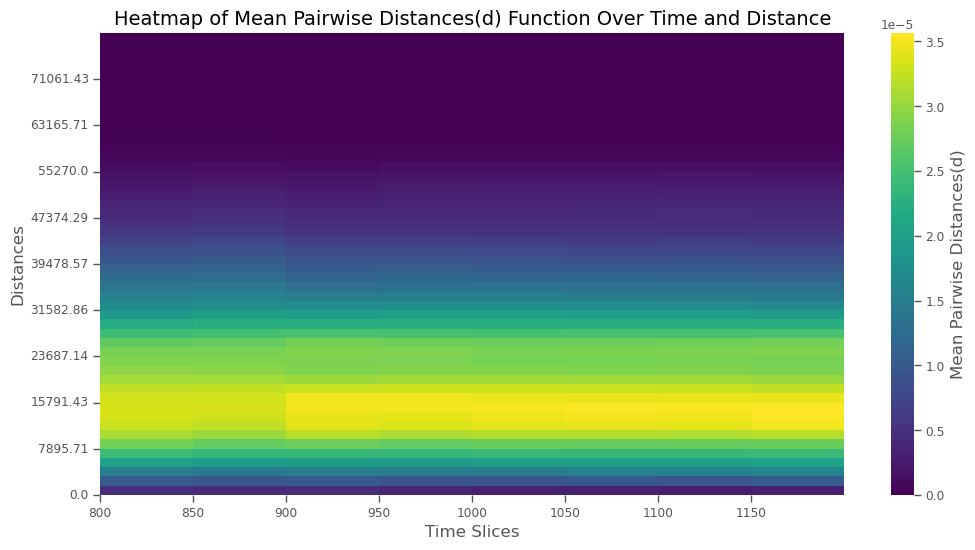

In [9]:
# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
num_iterations = 500
simulations_angkor = clustering.mc_samples(
    points, 
    time_slices=time_slices,  
    num_iterations=num_iterations
)

# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

# set consistent pairwise bandwidth (binning of distances)
use_kde = True
pair_bw = None
kde_sample_n = 50
kde_custom=cuml_kde

# Produce pairwise distances to explore clustering structure
pairwise_density_angkor, support_angkor = clustering.temporal_pairwise(
    simulations_angkor, 
    time_slices,
    bw=pair_bw, 
    use_kde=use_kde, 
    kde_sample_n=kde_sample_n,
    max_distance=max_distance,
    kde_custom=kde_custom
)

# Visualize clustering with heatmap
clustering_heatmap(
    pairwise_density_angkor,
    support_angkor,
    time_slices,
    result_type='Pairwise Distances',
    save = "../Output/pdd_hm_angkor.png"
)

#### Complete Spatial Randomness

#### Figure S3: Heatmap of Pairwise Distance Density versus Time for CSR based on Angkor's Temples

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Heatmap of Mean Pairwise Distances(d) Function Over Time and Distance'}, xlabel='Time Slices', ylabel='Distances'>)

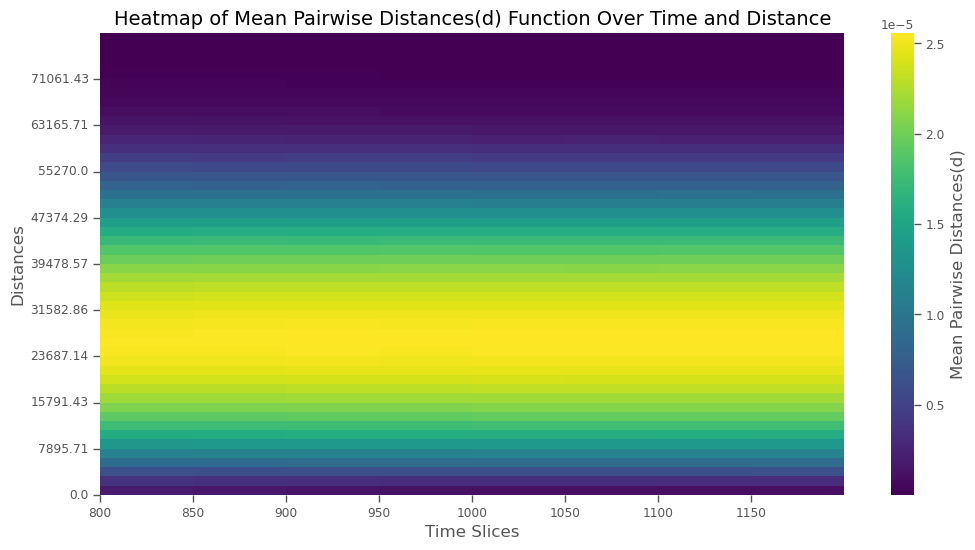

In [10]:
# Get MC iterations for incorporating chronological uncertainty and CSR
csr_simulations_angkor = clustering.mc_samples(
    points, 
    time_slices = time_slices,  
    num_iterations = num_iterations,
    null_model=clustering.csr_sample,
    x_min=x_min, 
    x_max=x_max,
    y_min=y_min, 
    y_max=y_max
)

# Calulate the pairwise distances for the CSR sample
csr_pairwise_density_angkor, csr_support_angkor = clustering.temporal_pairwise(
    csr_simulations_angkor, 
    time_slices, 
    bw = pair_bw, 
    use_kde = use_kde,
    kde_sample_n=kde_sample_n, 
    max_distance = max_distance,
    kde_custom=kde_custom
)

# Visualize clustering with heatmap
clustering_heatmap(
    csr_pairwise_density_angkor,
    csr_support_angkor,
    time_slices,
    result_type='Pairwise Distances'
)

#### Figure S4: Heatmap of PDD Statistical Significance compared to CSR for Angkor's Temples

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Probability Heat Map'}, xlabel='Time Slices', ylabel='Pairwise Distances'>)

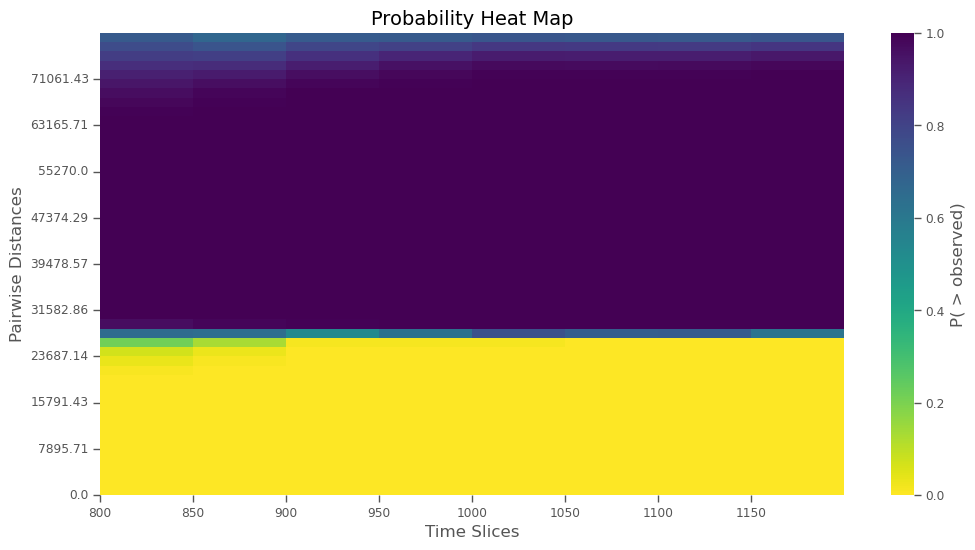

In [11]:
# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array_csr_angkor, diff_array_csr_angkor = clustering.p_diff(
    pairwise_density_angkor, 
    csr_pairwise_density_angkor
)

# Plot the heatmap of probabilities
pdiff_heatmap(
    p_diff_array_csr_angkor,
    time_slices,
    csr_support_angkor
)

#### Baseline-Informed Spatial Expectation

#### Figure S5: Heatmap of PDD statistical significance compared to BISE based on Angkor's Temples

In [12]:
# Get MC iterations for incorporating chronological uncertainty with BISE
bise_simulations_angkor = clustering.mc_samples(points, 
                                         time_slices, 
                                         num_iterations = num_iterations,
                                         null_model = clustering.bise)

# Calulate the pairwise distances for the LISE sample
bise_pairwise_density_angkor, bise_support_angkor = clustering.temporal_pairwise(
    bise_simulations_angkor, 
    time_slices, 
    bw = pair_bw, 
    use_kde = use_kde,
    kde_sample_n = kde_sample_n, 
    max_distance = max_distance,
    kde_custom = kde_custom
)

# Calculate the p-values for density differences between the observed points and 
# the simulated BISE baseline per distance and temporal slice
p_diff_array_bise_angkor, diff_array_bise_angkor = clustering.p_diff(
    pairwise_density_angkor, 
    bise_pairwise_density_angkor
)

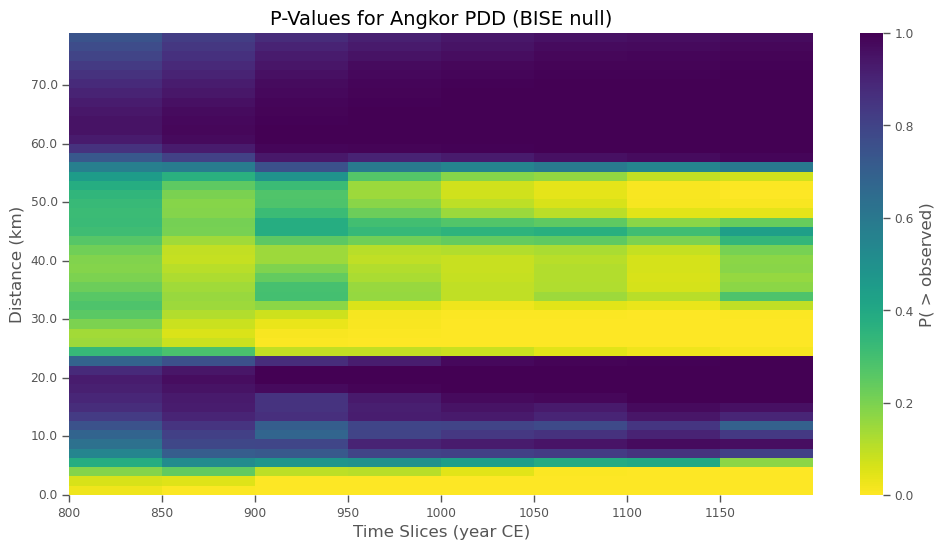

In [13]:
# Plot the heatmap of probabilities
fig, ax = pdiff_heatmap(
    p_diff_array_bise_angkor,
    time_slices,
    bise_support_angkor
)

# Custom ticks and labels here
tick_labels_km = np.arange(0, bise_support_angkor.max() / 1000, 10)
tick_labels_m = tick_labels_km * 1000
tick_positions = np.interp(
    tick_labels_m, 
    bise_support_angkor, 
    np.arange(len(bise_support_angkor))
)

ax.set_yticks(tick_positions)
ax.set_yticklabels(np.round(tick_labels_km, 1))
ax.set_ylabel("Distance (km)")

ax.set_xlabel("Time Slices (year CE)")
ax.set_title("P-Values for Angkor PDD (BISE null)")

plt.savefig("../Output/dpdd_hm_angkor.svg", bbox_inches='tight')
plt.savefig("../Output/dpdd_hm_angkor.png", bbox_inches='tight')

#### One Time Slice

#### Figure S6: Time Slice of PDD for Angkor compared to Null Models

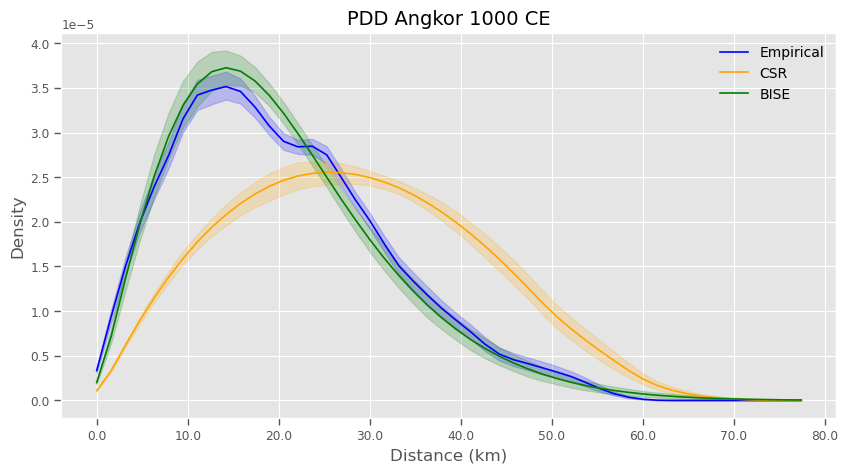

In [14]:
from chronocluster.utils import plot_pdd

time_slice_idx = np.where(time_slices == 1000)[0][0]

# List of density arrays
density_arrays = [
    pairwise_density_angkor, 
    csr_pairwise_density_angkor, 
    bise_pairwise_density_angkor
]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support_angkor,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Empirical", "CSR", "BISE"],
    colors=["blue", "orange", "green"]
)

ax.set_title("PDD Angkor 1000 CE")

# Get current tick positions and convert labels to km
x_ticks = ax.get_xticks()
ax.set_xticklabels(np.round(x_ticks / 1000, 1))  # e.g. 1000 → 1.0 km

# Update axis label
ax.set_xlabel("Distance (km)")

# Show the plot
plt.show()

fig.savefig("../Output/pdd_null_angkor.png", dpi=300, bbox_inches="tight")
fig.savefig("../Output/pdd_null_angkor.svg", bbox_inches="tight")

#### Figure S7: Difference between Angkor PDD and BISE Null at 1000 CE

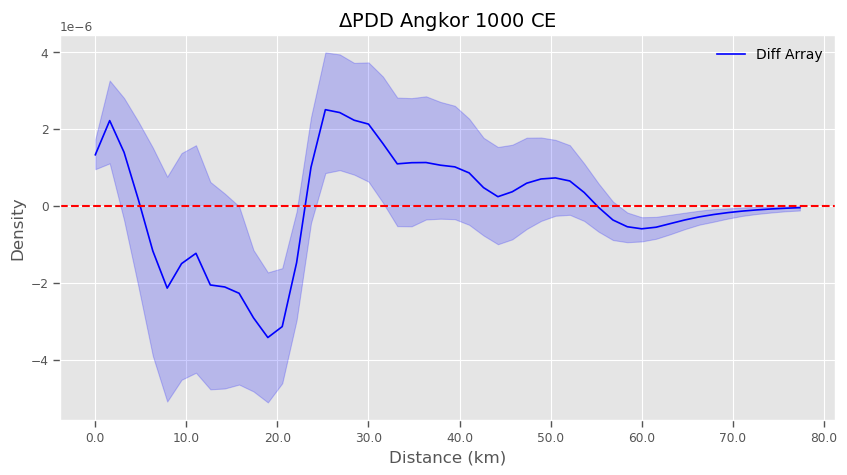

In [15]:
# List of density arrays
density_arrays = [diff_array_bise_angkor]

time_slice_idx = np.where(time_slices == 1000)[0][0]

# Generate the plot and get the figure and axis objects
fig1, ax1 = plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx,
    support=support_angkor,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Diff Array"],
    colors=["blue"]
)

# Add a horizontal line at y=0
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

ax1.set_title("$\Delta$PDD Angkor 1000 CE")
#ax1.set_xlabel("Distance (m)")

# Get current tick positions and convert labels to km
x_ticks = ax1.get_xticks()
ax1.set_xticklabels(np.round(x_ticks / 1000, 1))  # e.g. 1000 → 1.0 km

# Update axis label
ax1.set_xlabel("Distance (km)")

# Show the plot
plt.show()

fig.savefig("../Output/dpdd_t1000_angkor.png", dpi=300, bbox_inches="tight")
fig.savefig("../Output/dpdd_t1000_angkor.svg", bbox_inches="tight")

#### Series of Slices

#### Figure S8: Difference between Angkor PDD and BISE Null at 4 Time Slices

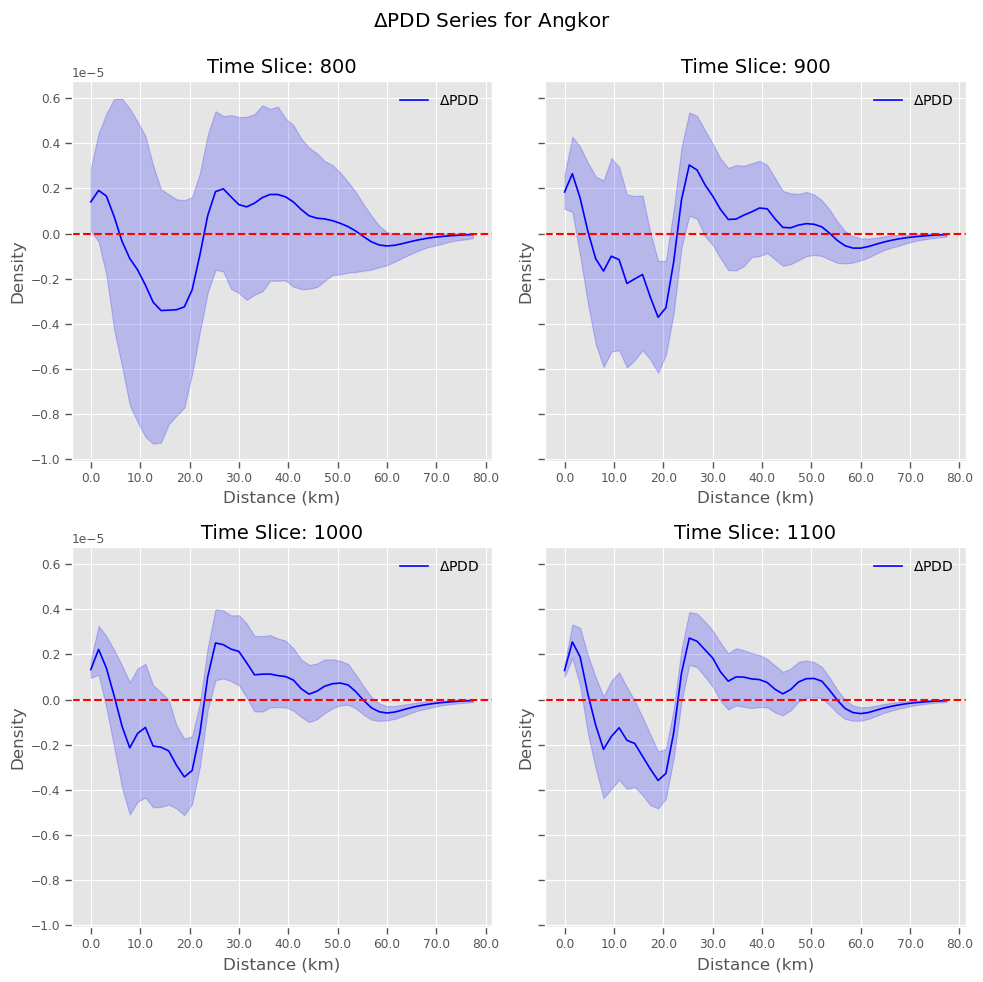

In [16]:
# List of time_slice_idx values
time_slice_indices = [0, 2, 4, 6]

# Create a figure and axes for subplots
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)  # 2 rows, 2 columns

axes_flat = axes.flatten()

# Loop through each time_slice_idx and generate the plots
for idx, (ax, time_slice_idx) in enumerate(zip(axes_flat, time_slice_indices)):
    # Generate the plot for the current time_slice_idx
    fig, _ = plot_pdd(
        time_slices=time_slices,
        time_slice_idx=time_slice_idx,
        support=support_angkor,
        density_arrays=density_arrays,
        quantiles=[0.025, 0.975],
        density_names=["$\Delta$PDD"],
        colors=["blue"],
        ax=ax
    )
    
    # Add a horizontal line (optional)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
    
    # Add a title for each panel
    ax.set_title(f"Time Slice: {time_slices[time_slice_idx]}")
    ax.set_xlabel("Distance (m)")
    # Get current tick positions and convert labels to km
    x_ticks = ax.get_xticks()
    ax.set_xticklabels(np.round(x_ticks / 1000, 1))  # e.g. 1000 → 1.0 km

    # Update axis label
    ax.set_xlabel("Distance (km)")

# Adjust layout and show the stitched plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("$\Delta$PDD Series for Angkor")
plt.show()

fig.savefig("../Output/dpdd_series_angkor.png", dpi=300, bbox_inches="tight")
fig.savefig("../Output/dpdd_series_angkor.svg", bbox_inches="tight")

## Hampshire County at Doomsday

### Data Wrangling

In [17]:
# data wrangling
doomsday_places = pd.read_csv('../Data/doomsday_places.csv')
doomsday_places = doomsday_places.dropna(subset=['easting', 'northing'])
doomsday_places

,PlacesIdx,County,Phillimore,Hundred,Vill,Area,XRefs,OSrefs,OScodes,lat,lon,easting,northing,start_date,end_date
0,1,WOR,"15,8",`Doddingtree',Abberley,NaN,NaN,SO7567,NaN,52.300561,-2.368032,375000.0,267000.0,1066,1086
1,6,ESS,"20,20. 24,51. 34,16",`Winstree',Abberton,NaN,NaN,TL9919,NaN,51.834157,0.886905,599000.0,219000.0,1066,1086
2,11,WOR,"9,1a",Pershore,Abberton,NaN,NaN,SO9953,NaN,52.175269,-2.016034,399000.0,253000.0,1066,1086
3,16,DOR,"13,1",`Uggescombe',Abbotsbury,NaN,NaN,SY5785,NaN,50.663064,-2.609752,357000.0,85000.0,1066,1086
4,21,DEV,"5,6",Merton,Abbotsham,NaN,NaN,SS4226,NaN,51.011615,-4.253705,242000.0,126000.0,1066,1086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13453,73861,STS,"2,22",Offlow,Yoxall,NaN,NaN,SK1419,NaN,52.768434,-1.793938,414000.0,319000.0,1066,1086
13454,73866,SUF,"7,18. 44,4",`Blything',Yoxford,NaN,NaN,TM3968,NaN,52.258228,1.500634,639000.0,268000.0,1066,1086
13455,73871,CHS,"FT1,4",Ati's Cross,Ysceifiog,Ati's Cross,NaN,SJ1571,NaN,53.229229,-3.274776,315000.0,371000.0,1066,1086
13456,73876,DEV,"6,3",North Tawton,Zeal Monachorum,NaN,NaN,SS7103,NaN,50.812135,-3.832415,271000.0,103000.0,1066,1086


Includes removing two problematic points in the data with a likely incorrect county labels.

In [18]:
# isolating Hampshire for comparison with Angkor
counties = ['HAM']
doomsday_df = doomsday_places[doomsday_places['County'].isin(counties)]

# I know there is a probable county designation error for the following point 
# (observed in QGIS as an kind of spatial outlier surrounded by points  with a 
# different designation and appears to be a duplicate point where the alternate 
# one has the same county designation as the other surrounding points)

# PlacesIdx of the mislabelled point is 10221 while the alternate is 10226
drop_idx = doomsday_df[doomsday_df['PlacesIdx'].isin([10221, 30086])].index
doomsday_df = doomsday_df.drop(drop_idx)

### Create Points List

In [19]:
doomsday_points = [
    clustering.Point(
        x=row['easting'],
        y=row['northing'],
        start_distribution = ddelta(1066),
        end_distribution = ddelta(1086)
    )
    for _, row in doomsday_df.iterrows()
]

# just double check the first ten look right
doomsday_points[:10]

[Point(x=456000.0, y=134000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=458000.0, y=88000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=459000.0, y=86000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=435000.0, y=86000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=456000.0, y=83000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=447000.0, y=117000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=427000.0, y=107000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=458000.0, y=133000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=471000.0, y=139000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086)),
 Point(x=460000.0, y=98000.0, start_distribution=ddelta(d=1066), end_distribution=ddelta(d=1086))]

### Define Time Slices and Spatial Limits

In [20]:
# Define the time slices
start_time = 1066
end_time = 1086
time_interval = 5
time_slices_ham = np.arange(start_time, end_time, time_interval)

# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(doomsday_points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

#### Figure S9: Spacetime Volume of Hampshire's Estates

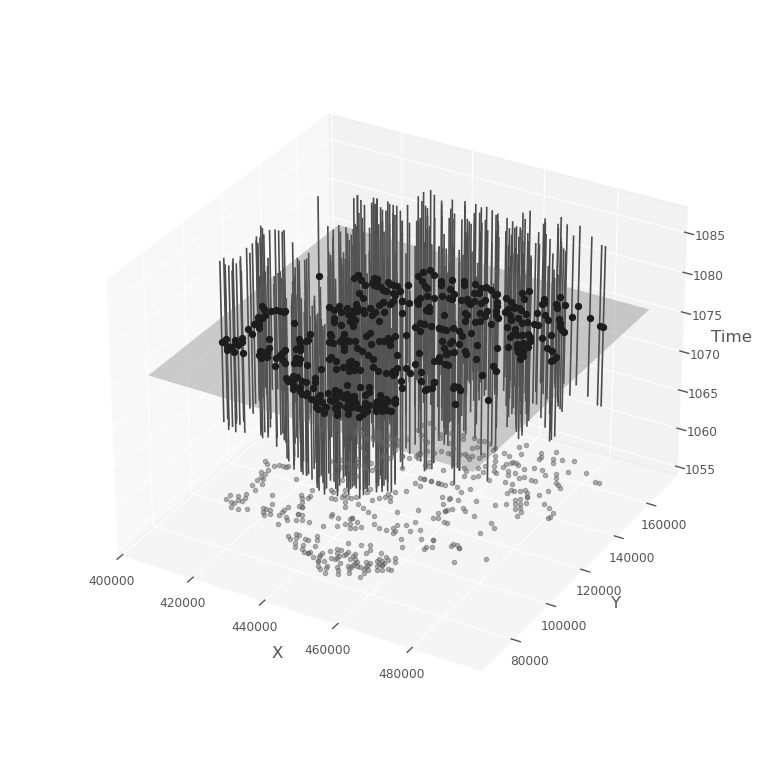

In [21]:
# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with 
# custom styling and a time slice plane
ax_stv_doomsday, fig_stv_doomsday = chrono_plot(
    doomsday_points, 
    style_params=style_params, 
    time_slice=1076,
    title='Hamphsire'
)
ax_stv_doomsday.set_box_aspect(None, zoom=0.85)
plt.savefig("../Output/spacetime_volume_Hampshire.svg", bbox_inches='tight')

Figure S10: 2D Spatiotemporal Point Scatters of Angkor's Temples and Hampshire's Estates

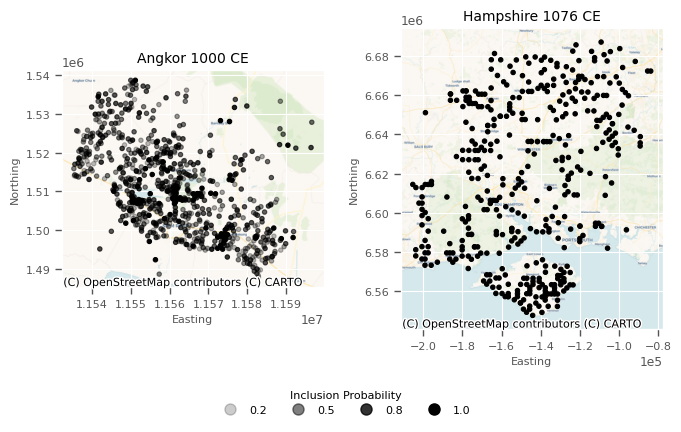

In [22]:
# Style
scatter_style = {
    "point_color": (0, 0, 0),
    "point_size": 10,
}

width_mm = 90  # Example width in mm
width_inch = width_mm / 25.4  # Convert mm to inches

# Create a figure with two subplots side by side (1 row, 2 columns)
fig, (ax_2d_angkor, ax_2d_hampshire) = plt.subplots(
    1, 
    2, 
    figsize = (2 * width_inch, 1.15 * width_inch)
)

y_delta = 0.18e6

# Plot for Angkor
ax_2d_angkor, fig_2d_angkor = chrono_plot2d(
    angkor_points,
    time = 1000,
    style_params = scatter_style,
    crs = "EPSG:32648",
    basemap_provider = ctx.providers.CartoDB.Voyager,
    ax = ax_2d_angkor,
)

ax_2d_angkor.set_title("Angkor 1000 CE", fontsize = 10)
ax_2d_angkor.set_xlabel("Easting", fontsize = 8)
ax_2d_angkor.set_ylabel("Northing", fontsize = 8)
ax_2d_angkor.tick_params(axis = 'both', labelsize = 8)

# Plot for Hampshire
ax_2d_hampshire, fig_2d_hampshire = chrono_plot2d(
    doomsday_points,
    time = 1076,
    style_params = scatter_style,
    crs = "EPSG:27700",
    basemap_provider = ctx.providers.CartoDB.Voyager,
    ax = ax_2d_hampshire,
)

ax_2d_hampshire.ticklabel_format(style = 'sci', scilimits = (0, 0))
ax_2d_hampshire.set_title("Hampshire 1076 CE", fontsize = 10)
ax_2d_hampshire.set_xlabel("Easting", fontsize = 8)
ax_2d_hampshire.set_ylabel("Northing", fontsize = 8)
ax_2d_hampshire.tick_params(axis = 'both', labelsize = 8)

inclusion_legend(
    ax = None, 
    shared = True, 
    fig = fig, 
    alphas = [0.2, 0.5, 0.8, 1.0]
)

# Adjust layout
fig.tight_layout(rect = [0, 1, 0, 1])

# Save figure
plt.savefig(
    "../Output/combined_inclusion_scatter.svg", 
    bbox_inches = "tight", 
    dpi = 300
)
plt.savefig(
    "../Output/combined_inclusion_scatter.png", 
    bbox_inches = "tight", 
    dpi = 300)

#### Figure S11: Spacetime Volumes for Angkor and Hampshire Combined

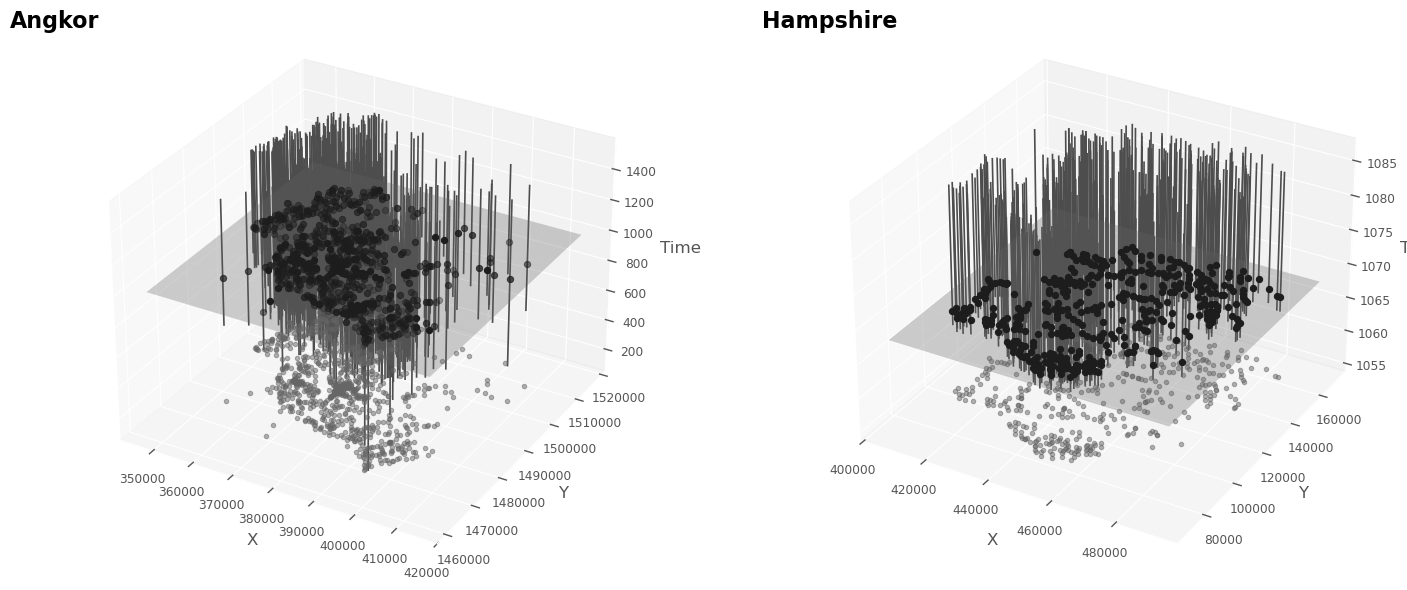

In [23]:
fig, axs = plt.subplots(
    1, 
    2, 
    figsize = (16, 6), 
    subplot_kw = {"projection": "3d"}
)

# Plot both datasets into subplots
chrono_plot(
    points, 
    ax = axs[0], 
    style_params = style_params, 
    time_slice = 1000
)
chrono_plot(
    doomsday_points, 
    ax = axs[1], 
    style_params = style_params, 
    time_slice = 1068
)

# Add panel labels
fig.text(
    0.05, 
    0.95, 
    "Angkor", 
    fontsize = 16, 
    weight = "bold", 
    transform = fig.transFigure
)
fig.text(
    0.52, 
    0.95, 
    "Hampshire", 
    fontsize = 16, 
    weight = "bold", 
    transform = fig.transFigure
)

# Save combined figure
fig.tight_layout()

# Z-axis labels (use labelpad to bring them in from the edge)
axs[0].set_zlabel("Time", labelpad = 10)
axs[0].ticklabel_format(style = 'plain', axis = 'both')  # or 'y' or 'both'
axs[1].set_zlabel("Time", labelpad = 10)
axs[1].ticklabel_format(style = 'plain', axis = 'both')  # or 'y' or 'both'


fig.savefig(
    "../Output/spacetime_volume_combined.png", 
    dpi = 300, 
    bbox_inches = "tight", 
    pad_inches = 1.0
)
fig.savefig(
    "../Output/spacetime_volume_combined.svg", 
    bbox_inches = "tight", 
    pad_inches = 1.0
)

In [24]:
# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
simulations_ham = clustering.mc_samples(
    doomsday_points, 
    time_slices = time_slices_ham,  
    num_iterations = num_iterations
)

### Sampling and Pairwise Distance Density Estimation

In [25]:
# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(doomsday_points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

# set consistent pairwise bandwidth (binning of distances)
# same as before with Angkor data

#### Figure S12: Heatmap of Pairwise Distance Density versus Time for Hampshire's Estates

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Heatmap of Mean Pairwise Distances(d) Function Over Time and Distance'}, xlabel='Time Slices', ylabel='Distances'>)

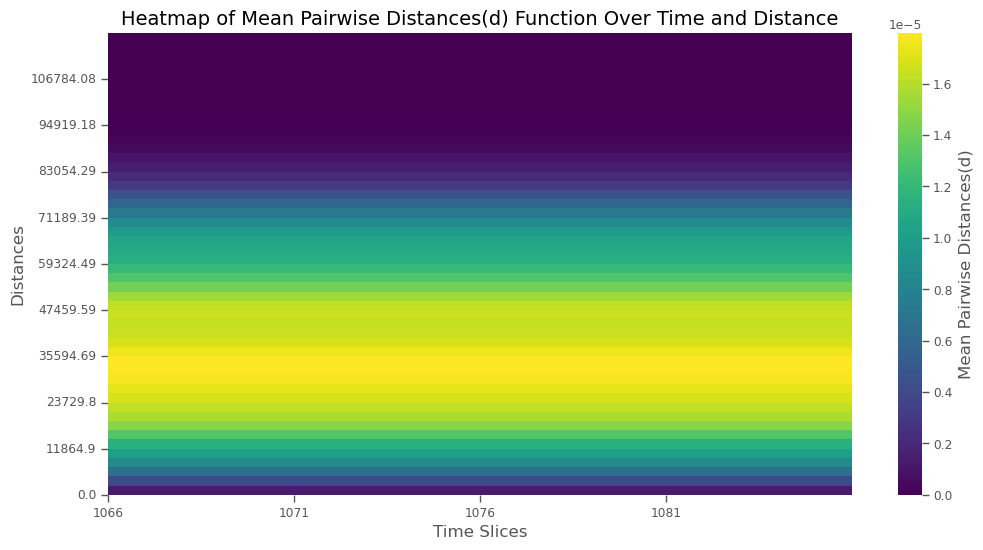

In [26]:
# Produce pairwise distances to explore clustering structure
pairwise_density_ham, support_ham = clustering.temporal_pairwise(
    simulations_ham, 
    time_slices_ham, 
    bw=pair_bw, 
    use_kde = use_kde, 
    kde_sample_n = kde_sample_n,
    max_distance = max_distance,
    kde_custom = kde_custom
)

# Visualize clustering with heatmap
clustering_heatmap(
    pairwise_density_ham,
    support_ham,
    time_slices_ham,
    result_type = 'Pairwise Distances'
)

#### Complete Spatial Randomness

#### Figure S13: Heatmap of PDD versus Time of CSR for Hampshire

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Heatmap of Mean Pairwise Distances(d) Function Over Time and Distance'}, xlabel='Time Slices', ylabel='Distances'>)

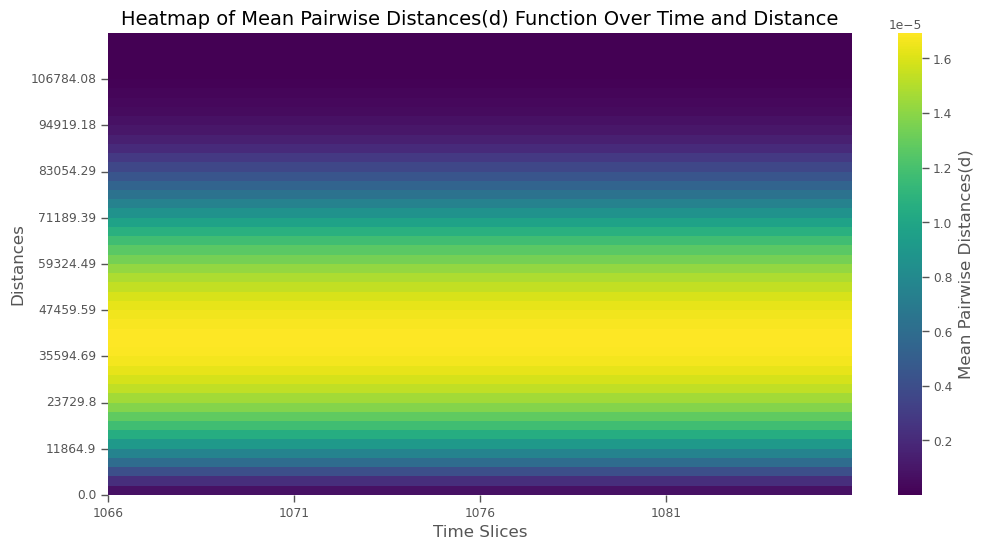

In [27]:
# Get MC iterations for incorporating chronological uncertainty and CSR
csr_simulations_ham = clustering.mc_samples(
    doomsday_points, 
    time_slices = time_slices_ham,  
    num_iterations = num_iterations,
    null_model = clustering.csr_sample,
    x_min = x_min, 
    x_max = x_max,
    y_min = y_min, 
    y_max = y_max
)

# Calulate the pairwise distances for the CSR sample
csr_pairwise_density_ham, csr_support_ham = clustering.temporal_pairwise(
    csr_simulations_ham, 
    time_slices_ham, 
    bw = pair_bw, 
    use_kde = use_kde,
    kde_sample_n = kde_sample_n, 
    max_distance = max_distance,
    kde_custom = kde_custom
)

# Visualize clustering with heatmap
clustering_heatmap(
    csr_pairwise_density_ham,
    csr_support_ham,
    time_slices_ham,
    result_type = 'Pairwise Distances'
)

#### Baseline-Informed Spatial Expectation

#### Figure S14: Heatmap of PDD Statistical Significance compred to BISE for Hampshire

(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Probability Heat Map'}, xlabel='Time Slices', ylabel='Pairwise Distances'>)

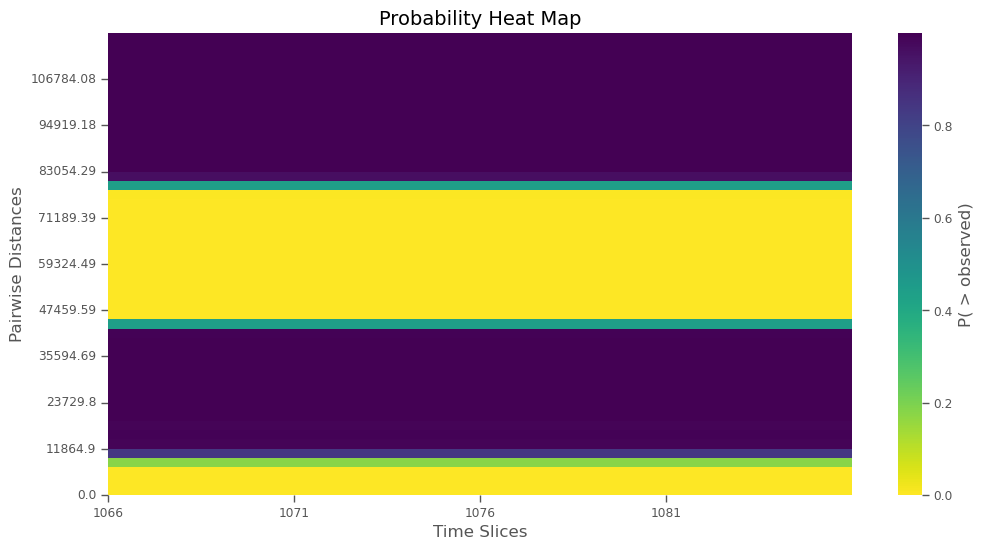

In [28]:
# Get MC iterations for incorporating chronological uncertainty with BISE
bise_simulations_ham = clustering.mc_samples(
    doomsday_points, 
    time_slices_ham, 
    num_iterations=num_iterations,
    null_model=clustering.bise
)

# Calulate the pairwise distances for the LISE sample
bise_pairwise_density_ham, bise_support_ham = clustering.temporal_pairwise(
    bise_simulations_ham, 
    time_slices_ham, 
    bw = pair_bw, 
    use_kde = use_kde,
    kde_sample_n=kde_sample_n, 
    max_distance = max_distance,
    kde_custom=kde_custom
)

# Calculate the p-values for density differences between 
# the observed points and the simulated CSR baseline per 
# distance and temporal slice
p_diff_array_bise_ham, diff_array_bise_ham = clustering.p_diff(
    pairwise_density_ham, 
    bise_pairwise_density_ham
)

# Plot the heatmap of probabilities
pdiff_heatmap(
    p_diff_array_bise_ham,
    time_slices_ham,
    bise_support_ham
)

#### One Time Slice

#### Figure S15: PDD of Hampshire Estates compared to CSR and BISE Null Models at 1066 CE

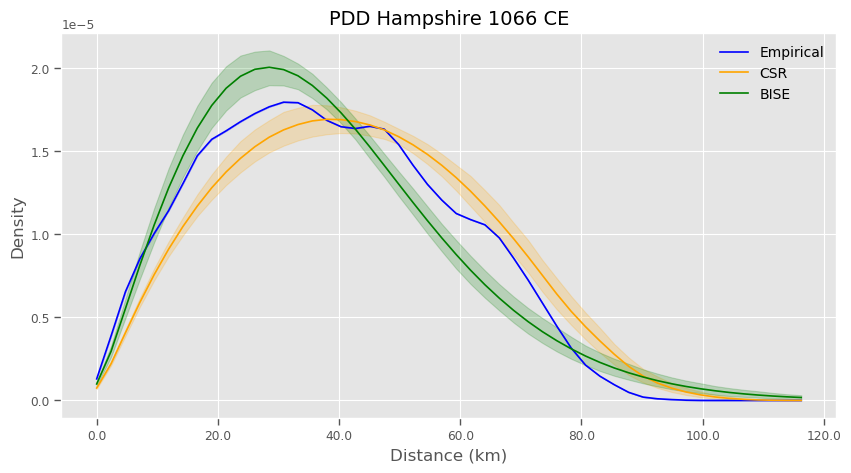

In [29]:
#from chronocluster.utils import plot_pdd
time_slice_idx = np.where(time_slices_ham == 1066)[0][0]

# List of density arrays
density_arrays = [
    pairwise_density_ham, 
    csr_pairwise_density_ham, 
    bise_pairwise_density_ham]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices_ham,
    time_slice_idx=time_slice_idx,
    support=support_ham,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["Empirical", "CSR", "BISE"],
    colors=["blue", "orange", "green"]
)

ax.set_title("PDD Hampshire 1066 CE")

# Get current tick positions and convert labels to km
x_ticks = ax.get_xticks()
ax.set_xticklabels(np.round(x_ticks / 1000, 1))  # e.g. 1000 → 1.0 km

# Update axis label
ax.set_xlabel("Distance (km)")

# Show the plot
plt.show()

fig.savefig(
    "../Output/pdd_null_hampshire.png", 
    dpi = 300, 
    bbox_inches = "tight"
)
fig.savefig(
    "../Output/pdd_null_hampshire.svg", 
    bbox_inches = "tight"
)

#### Figure S16: Difference between PDD and BISE Null Model for Hampshire's Estates at 1066 CE

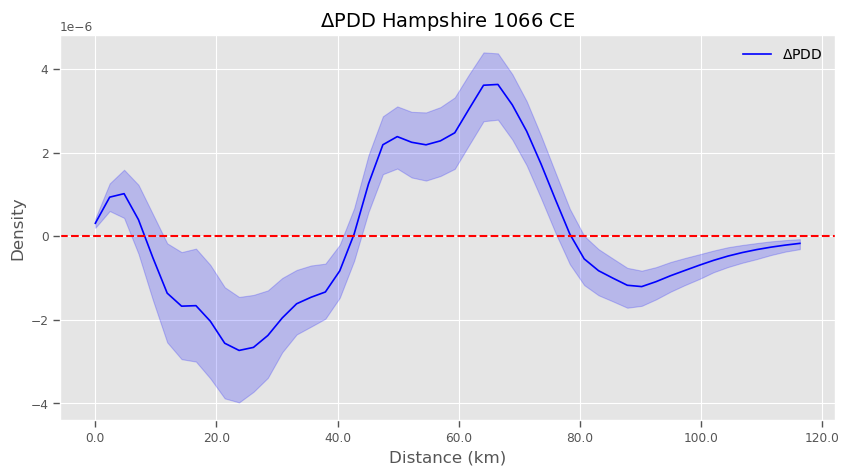

In [30]:
# List of density arrays
density_arrays = [diff_array_bise_ham]

# Generate the plot and get the figure and axis objects
fig, ax = plot_pdd(
    time_slices=time_slices_ham,
    time_slice_idx=time_slice_idx,
    support=support_ham,
    density_arrays=density_arrays,
    quantiles=[0.025, 0.975],
    density_names=["$\Delta$PDD"],
    colors=["blue"]
)

# Add a horizontal line at y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

ax.set_title("$\Delta$PDD Hampshire 1066 CE")
#ax.set_xlabel("Distance (m)")

# Get current tick positions and convert labels to km
x_ticks = ax.get_xticks()
ax.set_xticklabels(np.round(x_ticks / 1000, 1))  # e.g. 1000 → 1.0 km

# Update axis label
ax.set_xlabel("Distance (km)")

# Show the plot
plt.show()

#### Figure S17: $\Delta$ PDDs of Angkor and Hampshire Side by Side

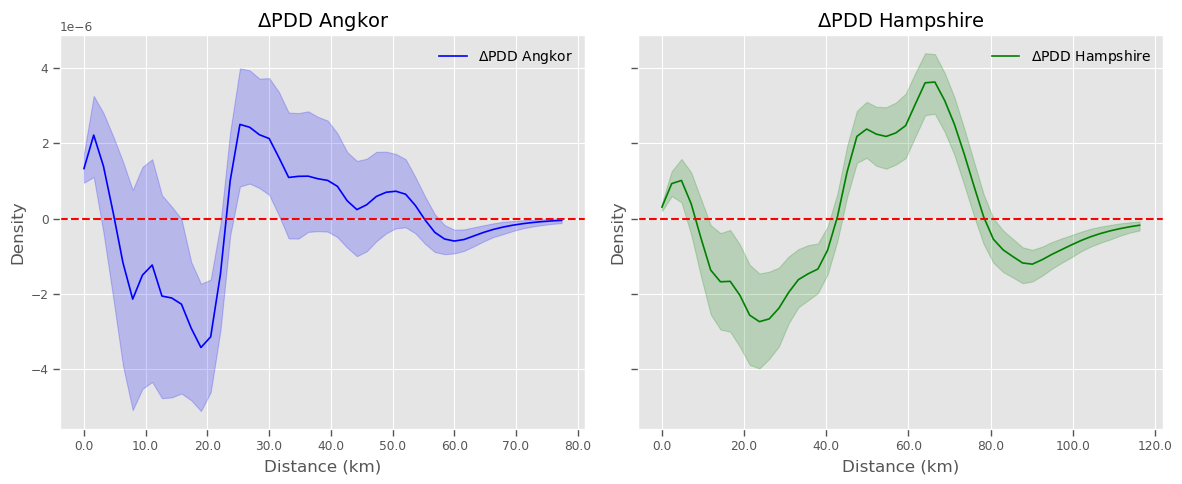

In [31]:
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=True)

# First plot, Angkor
time_slice_idx = np.where(time_slices == 1000)[0][0]
plot_pdd(
    time_slices = time_slices,
    time_slice_idx = time_slice_idx,
    support = support_angkor,
    density_arrays = [diff_array_bise_angkor],
    quantiles = [0.025, 0.975],
    density_names = ["$\Delta$PDD Angkor"],
    colors = ["blue"],
    ax=ax1
)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax1.set_title("$\Delta$PDD Angkor")
#ax1.set_xlabel("Distance (m)")

# Get current tick positions and convert labels to km
x_ticks = ax1.get_xticks()
ax1.set_xticklabels(np.round(x_ticks / 1000, 1))  # e.g. 1000 → 1.0 km

# Update axis label
ax1.set_xlabel("Distance (km)")

# Second plot, Hampshire
time_slice_idx = np.where(time_slices_ham == 1066)[0][0]
plot_pdd(
    time_slices = time_slices_ham,
    time_slice_idx = time_slice_idx,
    support = support_ham,
    density_arrays = [diff_array_bise_ham],
    quantiles = [0.025, 0.975],
    density_names = ["$\Delta$PDD Hampshire"],
    colors = ["green"],
    ax=ax2
)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
ax2.set_title("$\Delta$PDD Hampshire")
#ax2.set_xlabel("Distance (m)")

# Get current tick positions and convert labels to km
x_ticks = ax2.get_xticks()
ax2.set_xticklabels(np.round(x_ticks / 1000, 1))  # e.g. 1000 → 1.0 km

# Update axis label
ax2.set_xlabel("Distance (km)")

# Adjust layout and show the combined plot
plt.tight_layout()
plt.show()

fig.savefig(
    "../Output/dpdd_compared.png", 
    dpi = 300, 
    bbox_inches = "tight"
)
fig.savefig(
    "../Output/dpdd_compared.svg", 
    bbox_inches = "tight"
)

#### Figure S18: $\Delta$ PDDs compared with Angkor's PDD Scaled

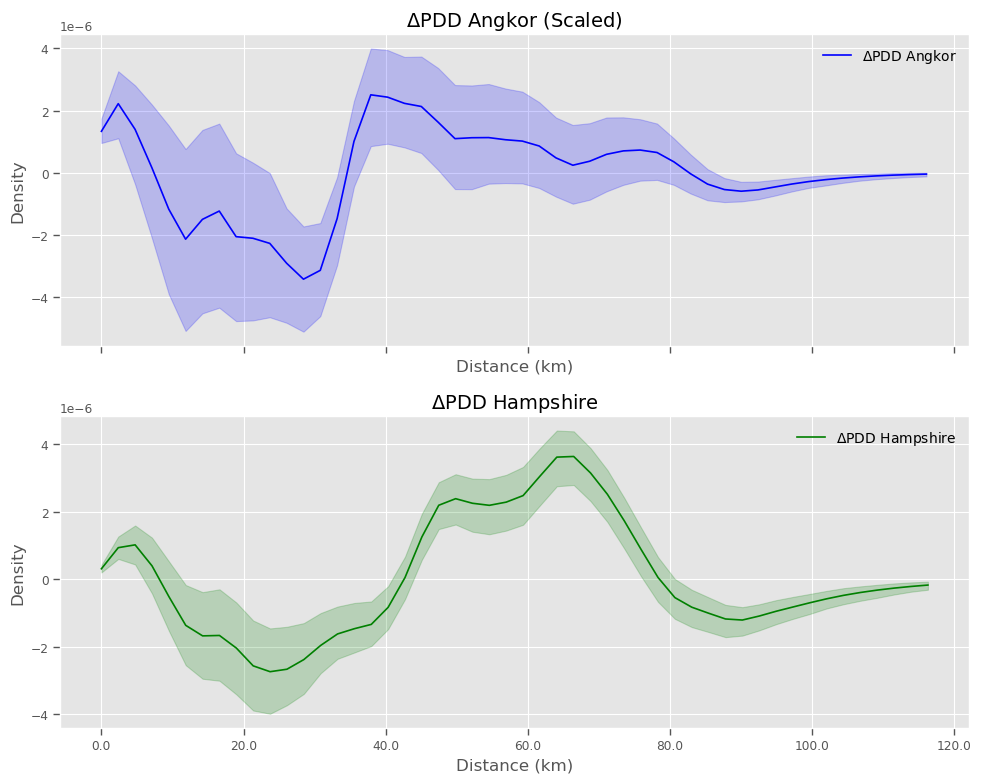

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Scaling ratio for Angkor x-axis
scaling_ratio = 1.5
scaled_support_angkor = np.array(support_angkor) * scaling_ratio

# Create a vertically stacked figure with shared x-axis
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(10, 8),
    sharex=True,
    gridspec_kw={'height_ratios': [1, 1]}
)

# First plot: Angkor (scaled x-axis)
time_slice_idx_angkor = np.where(time_slices == 1000)[0][0]
plot_pdd(
    time_slices=time_slices,
    time_slice_idx=time_slice_idx_angkor,
    support=scaled_support_angkor,
    density_arrays=[diff_array_bise_angkor],
    quantiles=[0.025, 0.975],
    density_names=["$\Delta$PDD Angkor"],
    colors=["blue"],
    ax=ax1
)
ax1.set_title("$\Delta$PDD Angkor (Scaled)")
ax1.tick_params(labelbottom=False)
#ax1.set_xlabel("Distance (m)")

# Get current tick positions and convert labels to km
x_ticks = ax1.get_xticks()
ax1.set_xticklabels(np.round(x_ticks / 1000, 1))  # e.g. 1000 → 1.0 km

# Update axis label
ax1.set_xlabel("Distance (km)")

# Second plot: Hampshire
time_slice_idx_ham = np.where(time_slices_ham == 1066)[0][0]
plot_pdd(
    time_slices = time_slices_ham,
    time_slice_idx = time_slice_idx_ham,
    support = support_ham,
    density_arrays = [diff_array_bise_ham],
    quantiles = [0.025, 0.975],
    density_names = ["$\Delta$PDD Hampshire"],
    colors = ["green"],
    ax=ax2
)
ax2.set_title("$\Delta$PDD Hampshire")
#ax2.set_xlabel("Distance (m)")

# Get current tick positions and convert labels to km
x_ticks = ax2.get_xticks()
ax2.set_xticklabels(np.round(x_ticks / 1000, 1))  # e.g. 1000 → 1.0 km

# Update axis label
ax2.set_xlabel("Distance (km)")

# Final layout tweaks
plt.tight_layout()
plt.show()

fig.savefig(
    "../Output/dpdd_scaled.png", 
    dpi=300, 
    bbox_inches="tight"
)
fig.savefig(
    "../Output/dpdd_scaled.svg", 
    bbox_inches="tight"
)


## First Peaks

In [33]:
from scipy.signal import find_peaks
import warnings

def find_first_peak(pdd_slice, support):
    """
    Finds the first peak in a PDD slice.

    Parameters:
    -----------
    pdd_slice : np.ndarray
        A 1D array of PDD values for a single realization.
    support : np.ndarray
        Array of distance values (x-axis).

    Returns:
    --------
    float
        Distance (x-coordinate) of the first peak.
    """
    # Find all peaks in the PDD slice
    peaks, _ = find_peaks(pdd_slice)

    # If peaks exist, return the first one
    if len(peaks) > 0:
        return support[peaks[0]]

    # If no peaks are found, return NaN
    return np.nan

def find_all_first_peaks(diff_array, support, time_slice_idx):
    """
    Finds the first peak for all realizations in a PDD difference array and returns 
    both the peak locations and their corresponding densities.

    Parameters:
    -----------
    diff_array : np.ndarray
        3D array of PDD difference values (distances x time_slices x realizations).
    support : np.ndarray
        Array of distance values (x-axis).
    time_slice_idx : int
        Index of the time slice to analyze.

    Returns:
    --------
    peaks : list
        List of first peak locations for all realizations.
    densities : list
        List of density values at the first peak for all realizations.
    """
    peaks = []
    densities = []
    num_realizations = diff_array.shape[2]

    for realization_idx in range(num_realizations):
        # Extract the PDD slice for the current realization
        pdd_slice = diff_array[:, time_slice_idx, realization_idx]

        # Find the first peak location
        peak_location = find_first_peak(pdd_slice, support)
        
        # if no peak, just return nan
        if np.isnan(peak_location):
            warnings.warn("No peak found.", UserWarning)
            peaks.append(np.nan)
            densities.append(np.nan)
        else:
            # Get the density value at the peak
            peak_density = pdd_slice[support == peak_location][0]

            # Append results
            peaks.append(peak_location)
            densities.append(peak_density)

    return np.array(peaks), np.array(densities)


### Set Common Parameters

In [34]:
num_iterations = 500
use_kde = True
pair_bw = None
kde_sample_n = 100
kde_custom=cuml_kde
max_distance = 15000

### Angkor First Peak


In [35]:
time_slice = 1100

# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
simulations = clustering.mc_samples(
    points, 
    time_slices=[time_slice],  
    num_iterations=num_iterations
)

# Produce pairwise distances to explore clustering structure
pairwise_density_angkor, support_angkor = clustering.temporal_pairwise(
    simulations, 
    [time_slice],
    bw=pair_bw, 
    use_kde=use_kde, 
    kde_sample_n=kde_sample_n,
    max_distance=max_distance,
    kde_custom=kde_custom
)

# Get MC iterations for incorporating chronological uncertainty with BISE
bise_simulations = clustering.mc_samples(
    points, 
    [time_slice], 
    num_iterations=num_iterations,
    null_model=clustering.bise
)

# Calulate the pairwise distances for the LISE sample
bise_pairwise_density_angkor, bise_support_angkor = clustering.temporal_pairwise(
    bise_simulations, 
    [time_slice], 
    bw = pair_bw, 
    use_kde = use_kde,
    kde_sample_n=kde_sample_n, 
    max_distance = max_distance,
    kde_custom=kde_custom
)

# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array_angkor, diff_array_angkor = clustering.p_diff(
    pairwise_density_angkor, 
    bise_pairwise_density_angkor
)

In [36]:
p_pdd_peaks_angkor, _ = find_all_first_peaks(
    diff_array_angkor, 
    support_angkor, 
    0
)

# Convert to a Pandas DataFrame and use describe()
summary_stats = pd.DataFrame(p_pdd_peaks_angkor, columns=["Values"]).describe()

# Display the summary statistics
summary_stats

,Values
count,500.000000
mean,1723.939394
std,279.623577
min,909.090909
25%,1515.151515
50%,1666.666667
75%,1969.696970
max,2878.787879


#### Figure S19: Distribution of First Peak Locations for Angkor at 1000 CE

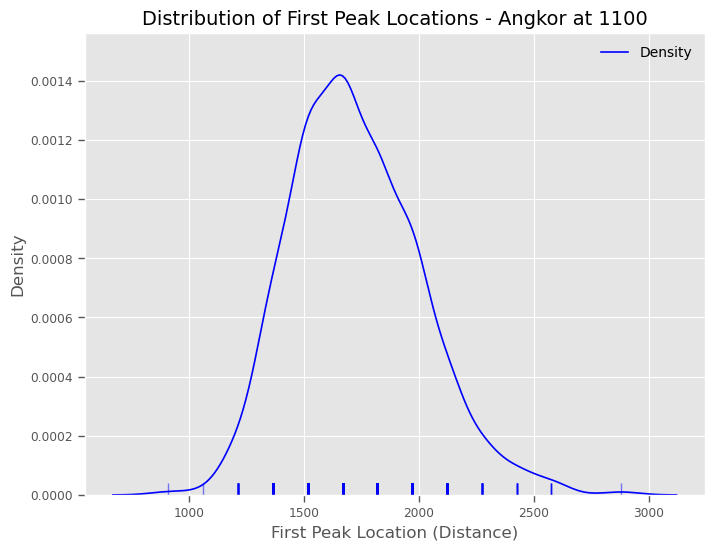

In [37]:
# Assuming `peaks` is your data
# Plot density and rug plot
plt.figure(figsize=(8, 6))
sns.kdeplot(p_pdd_peaks_angkor, color='blue', label="Density")
sns.rugplot(p_pdd_peaks_angkor, color='blue', alpha=0.5)

# Add labels and title
plt.xlabel("First Peak Location (Distance)")
plt.ylabel("Density")
plt.title(f"Distribution of First Peak Locations - Angkor at {time_slice}")
plt.legend()

# Show the plot
plt.show()

### Hampshire First Peak

In [38]:
time_slice = 1066

# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
simulations = clustering.mc_samples(
    doomsday_points, 
    time_slices=[time_slice],  
    num_iterations=num_iterations
)

# Produce pairwise distances to explore clustering structure
pairwise_density_hampshire, support_hampshire = clustering.temporal_pairwise(
    simulations, 
    [time_slice],
    bw=pair_bw, 
    use_kde=use_kde, 
    kde_sample_n=kde_sample_n,
    max_distance=max_distance,
    kde_custom=kde_custom
)

# Get MC iterations for incorporating chronological uncertainty with BISE
bise_simulations = clustering.mc_samples(
    doomsday_points, 
    [time_slice], 
    num_iterations=num_iterations,
    null_model=clustering.bise
)

# Calulate the pairwise distances for the BISE sample
bise_pairwise_density_hampshire, bise_support_hampshire = clustering.temporal_pairwise(
    bise_simulations, 
    [time_slice], 
    bw = pair_bw, 
    use_kde = use_kde,
    kde_sample_n=kde_sample_n, 
    max_distance = max_distance,
    kde_custom=kde_custom
)

# Calculate the p-values for density differences between the observed points 
# and the simulated CSR baseline per distance and temporal slice
p_diff_array_hampshire, diff_array_hampshire = clustering.p_diff(
    pairwise_density_hampshire, 
    bise_pairwise_density_hampshire
)

In [39]:
p_pdd_peaks_hampshire, _ = find_all_first_peaks(
    diff_array_hampshire, 
    support_hampshire, 
    0
)

# Convert to a Pandas DataFrame and use describe()
summary_stats = pd.DataFrame(
    p_pdd_peaks_hampshire, 
    columns = ["Values"]
).describe()

# Display the summary statistics
summary_stats

,Values
count,500.000000
mean,3793.636364
std,419.669614
min,2121.212121
25%,3484.848485
50%,3787.878788
75%,4090.909091
max,5000.000000


#### Figure S20: Distribution of First Peak Locations for Hampshire at 1066 CE

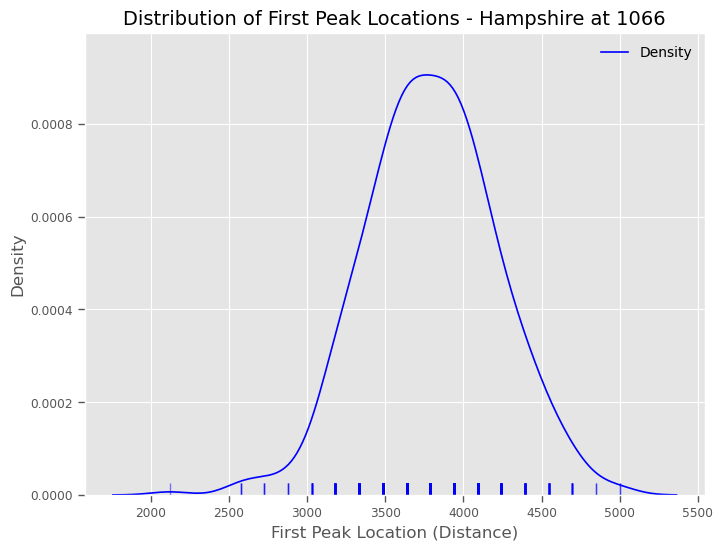

In [40]:
# Assuming `peaks` is your data
# Plot density and rug plot
plt.figure(figsize=(8, 6))
sns.kdeplot(p_pdd_peaks_hampshire, color='blue', label="Density")
sns.rugplot(p_pdd_peaks_hampshire, color='blue', alpha=0.5)

# Add labels and title
plt.xlabel("First Peak Location (Distance)")
plt.ylabel("Density")
plt.title(f"Distribution of First Peak Locations - Hampshire at {time_slice}")
plt.legend()

# Show the plot
plt.show()

### Difference Distribution

#### Figure S21: Distribution of First Peak Location Differences between Angkor and Hampshire

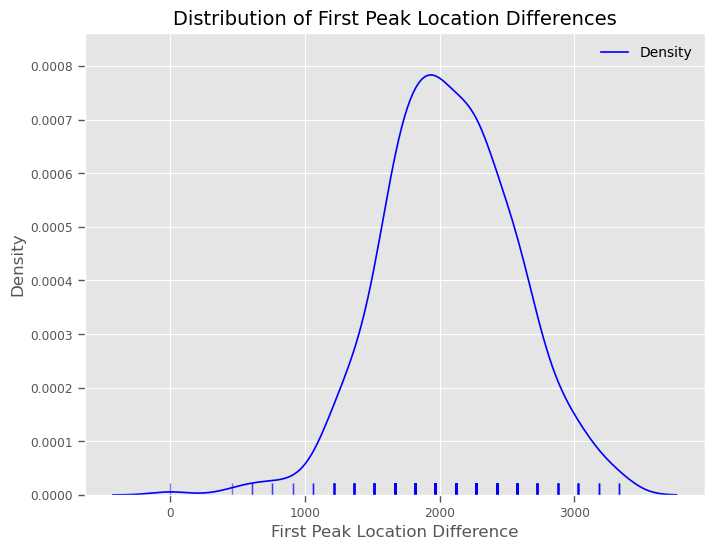

In [41]:
# Assuming `peaks` is your data
# Plot density and rug plot
plt.figure(figsize=(8, 6))
sns.kdeplot(
    p_pdd_peaks_hampshire - p_pdd_peaks_angkor, 
    color = 'blue', 
    label = "Density")
sns.rugplot(
    p_pdd_peaks_hampshire - p_pdd_peaks_angkor, 
    color = 'blue', 
    alpha = 0.5)

# Add labels and title
plt.xlabel("First Peak Location Difference")
plt.ylabel("Density")
plt.title("Distribution of First Peak Location Differences")
plt.legend()

# Show the plot
plt.show()

In [42]:
# Convert to a Pandas DataFrame and use describe()
summary_stats = pd.DataFrame(
    p_pdd_peaks_hampshire / p_pdd_peaks_angkor, 
    columns = ["Values"]
).describe()

# Display the summary statistics
summary_stats

,Values
count,500.000000
mean,2.256439
std,0.434235
min,1.000000
25%,1.927198
50%,2.181818
75%,2.545455
max,3.750000


#### Figure S22: Distribution of First Peal Location Ratios between Angkor and Hampshire

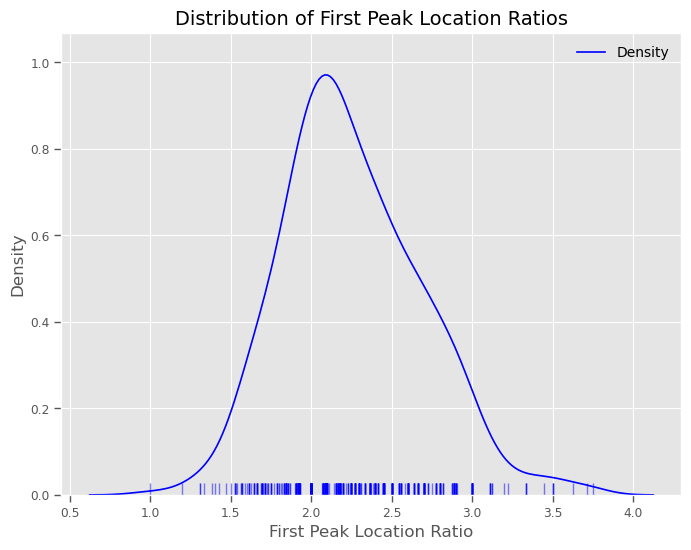

In [43]:
# Assuming `peaks` is your data
# Plot density and rug plot
plt.figure(figsize=(8, 6))
sns.kdeplot(
    p_pdd_peaks_hampshire / p_pdd_peaks_angkor, 
    color = 'blue', 
    label = "Density"
)
sns.rugplot(
    p_pdd_peaks_hampshire / p_pdd_peaks_angkor, 
    color = 'blue', 
    alpha = 0.5
)

# Add labels and title
plt.xlabel("First Peak Location Ratio")
plt.ylabel("Density")
plt.title("Distribution of First Peak Location Ratios")
plt.legend()

# Show the plot
plt.show()

## Extended Analyses

In [ ]:
# get unique list of counties
counties = doomsday_places['County'].unique()

# Ensure the Output directory exists
output_dir = "../Output"
os.makedirs(output_dir, exist_ok=True)

# loop over it
for j in tqdm(counties, desc="Processing Counties"):
    # isolate j
    doomsday_df = doomsday_places[doomsday_places['County'] == j]

    # create list of points
    doomsday_points = [
    clustering.Point(
        x=row['easting'],
        y=row['northing'],
        start_distribution = ddelta(1066),
        end_distribution = ddelta(1086)
    )
    for _, row in doomsday_df.iterrows()
    ]

    # Define the time slices
    start_time = 1066
    end_time = 1086
    time_interval = 5
    time_slices = np.arange(start_time, end_time, time_interval)
    time_slices

    # Get a bounding box for use later and to extract sensible distance limits
    x_min, y_min, x_max, y_max = get_box(doomsday_points)
    max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))

    # Run the Monte Carlo simulation to get an ensemble of probable 
    # lists of points included in each time slice.
    num_iterations = 500


    # set consistent pairwise bandwidth (binning of distances)
    use_kde = True
    pair_bw = None
    kde_sample_n = 50
    kde_custom=cuml_kde

    # Run the Monte Carlo simulation to get an ensemble of probable 
    # lists of points included in each time slice.
    simulations = clustering.mc_samples(doomsday_points, 
                                        time_slices=time_slices,  
                                        num_iterations=num_iterations)

    # set consistent pairwise bandwidth (binning of distances)
    # same as before with Angkor data
    # Produce pairwise distances to explore clustering structure
    pairwise_density, support = clustering.temporal_pairwise(
        simulations, 
        time_slices, 
        bw = pair_bw, 
        use_kde = use_kde, 
        kde_sample_n = kde_sample_n,
        max_distance = max_distance,
        kde_custom = kde_custom
    )
    
    # Get MC iterations for incorporating chronological uncertainty with BISE
    bise_simulations = clustering.mc_samples(
        doomsday_points, 
        time_slices, 
        num_iterations=num_iterations,
        null_model=clustering.bise
    )

    # Calulate the pairwise distances for the LISE sample
    bise_pairwise_density, bise_support = clustering.temporal_pairwise(
        bise_simulations, 
        time_slices, 
        bw = pair_bw, 
        use_kde = use_kde,
        kde_sample_n=kde_sample_n, 
        max_distance = max_distance,
        kde_custom=kde_custom
    )

    # Calculate the p-values for density differences between the observed points and 
    # the simulated CSR baseline per distance and temporal slice
    p_diff_array, diff_array = clustering.p_diff(
        pairwise_density, 
        bise_pairwise_density
    )

    #from chronocluster.utils import plot_pdd
    time_slice_idx = np.where(time_slices == 1066)[0][0]

    # List of density arrays
    density_arrays = [diff_array]

    # Generate the plot and get the figure and axis objects
    fig, ax = plot_pdd(
        time_slices=time_slices,
        time_slice_idx=time_slice_idx,
        support=support,
        density_arrays=density_arrays,
        quantiles=[0.025, 0.975],
        density_names=["Diff Array"],
        colors=["blue"]
    )

    # Add a horizontal line at y=0
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

    # Save the plot to the Output directory
    output_path = os.path.join(output_dir, f"pdd_{j}.png")

    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    # Close the plot to free memory
    plt.close(fig)